In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import os
import re
import pickle as pk
from scipy.signal import hilbert
from statsmodels.tsa.seasonal import seasonal_decompose


In [89]:
path =  'd:/Git_Proyects/Tesis/Faiss_vect/'
citas = pk.load(open(path+'cita_media_cluster_october.pk', 'rb'))

In [46]:
index = 104
df_clus_completo = pd.read_csv(path+f'Tw_mas_RT_august/RT_Tw_cluster_{index}.csv')
df_clus_completo['Fecha'] = pd.to_datetime(df_clus_completo['Fecha'], format='%a %b %d %H:%M:%S +0000 %Y')
df_clus_completo['HorasDesdeInicio'] = (df_clus_completo['Fecha'] - df_clus_completo['Fecha'].min()).dt.total_seconds() / 3600

categoria = 'RT'

df_categoria_true = df_clus_completo[df_clus_completo[categoria] == True]
df_categoria_false = df_clus_completo[df_clus_completo[categoria] == False]

df_categoria = [df_categoria_true, df_categoria_false]
labels = ['RT', 'Tw originales']

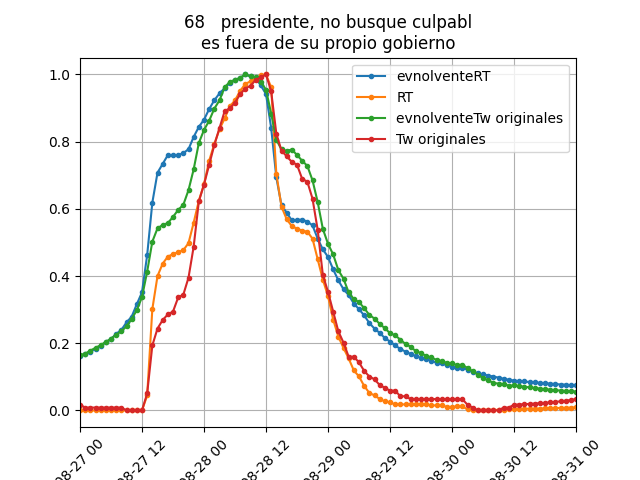

In [30]:
%matplotlib widget
plt.figure()
firstpart, secondpart = citas[index][:len(citas[index])//2], citas[index][len(citas[index])//2:]
plt.title(str(index)+'   ' + firstpart+'\n'+secondpart)
for i, df1 in enumerate(df_categoria):
    df = df1.copy()
    df_index = df.set_index('Fecha')
    df_count_hora = df_index.resample('1H').count()
    analytic_signal = hilbert(df_count_hora['Tweets'])
    amplitude_envelope = np.abs(analytic_signal)
    #plt.plot(df_count_hora.index, df_count_hora['Tweets']/max(df_count_hora['Tweets']), label = 'crudo '+str(labels[i]), marker = '.') #Test comparation

    env = pd.DataFrame({'Fecha':df_count_hora.index, 'env':amplitude_envelope})
    env_index = env.set_index('Fecha')
    env_suav = env_index.rolling('1D', center=True).mean()
    plt.plot(env_suav.index, env_suav['env']/max(env_suav['env']), label ='evnolvente' + str(labels[i]), marker = '.', linestyle = 'solid')
    #plt.plot(df_count_hora.index, df_count_hora['Tweets'], label = 'crudo '+str(labels[i]), marker = '.') 
    df_suavizado = df_count_hora.rolling('1D', center = True).mean()
    df_suavizado_2 = df_count_hora.ewm( alpha = 0.1).mean()

    plt.plot(df_suavizado.index, df_suavizado['Tweets']/max(df_suavizado['Tweets']), label = labels[i], marker = '.', linestyle = 'solid')
    #plt.plot(df_suavizado_2.index, df_suavizado_2['Tweets'], label = 'filltro ewp', marker = '.', linestyle = 'solid', color = 'k')

#plt.xticks(pd.date_range(start=df_clus_completo['Fecha'].min(), end=df_clus_completo['Fecha'].max(), freq='12H')
#           , labels= (np.arange(df_clus_completo['HorasDesdeInicio'].min(), df_clus_completo['HorasDesdeInicio'].max(), 12)-336))
plt.legend()
plt.grid(0.7)
plt.xticks(rotation=45)
fecha_inicio = pd.to_datetime('2019-08-27')
fecha_fin = pd.to_datetime('2019-08-31')
plt.xlim([fecha_inicio, fecha_fin])
#plt.savefig(path+f'imagenes_agosto/serie_{index}.png')
plt.show()

In [12]:
a = pd.DataFrame({'Fecha':df_count_hora.index, 'env':amplitude_envelope})
a = a.set_index('Fecha')
a.rolling('1D', center=True).mean()

,env
Fecha,
2019-08-01 23:00:00,0.608982
2019-08-02 00:00:00,0.626754
2019-08-02 01:00:00,0.654584
2019-08-02 02:00:00,0.642558
2019-08-02 03:00:00,0.723495
...,...
2019-08-29 16:00:00,1.064173
2019-08-29 17:00:00,1.126051
2019-08-29 18:00:00,1.175316


In [29]:
citas[46]

'ahora no hay nadie tomando deuda argentina ni nadie que pueda pagarla. argentina está en un default virtual, escondido'

Guardando todo junto, prueba

In [129]:
def graficar_y_guardar(list_df, citas, index, df_clus_completo):
    plt.figure()
    firstpart, secondpart = citas[index][:len(citas[index])//2], citas[index][len(citas[index])//2:]
    plt.title(str(index)+'   ' + firstpart+'\n'+secondpart)
    colors1 = ['cornflowerblue', 'orange']
    colors2 = ['midnightblue', 'red']
    for i, df1 in enumerate(list_df):
        df = df1.copy()
        df_index = df.set_index('Fecha')
        df_count_hora = df_index.resample('1H').count()
        result = seasonal_decompose(df_count_hora['Tweets'], model='additive')
        trend = result.trend.fillna(0)
        plt.plot(df_count_hora.index, df_count_hora['Tweets']/max(df_count_hora['Tweets']), label = 'crudo '+str(labels[i]), marker = '.', color = colors1[i]) #Test comparation
        plt.plot(trend/max(trend), label = 'tendencia ' + labels[i], color = colors2[i])
        #df_suavizado = df_count_hora.rolling('1D', center = True).mean()
        #df_suavizado.index = pd.to_datetime(df_suavizado.index) - pd.Timedelta(hours=8)
        #plt.plot(df_suavizado.index, df_suavizado['Tweets']/max(df_suavizado['Tweets']), label = labels[i], marker = '.', linestyle = 'solid')

    fecha_max_apariciones = trend.idxmax()
    fecha_inicio = fecha_max_apariciones - pd.Timedelta(days=1)
    fecha_fin = fecha_max_apariciones + pd.Timedelta(days=4)
    ag_str = "2019-08-01 00:00:00"
    inicio_ag = pd.to_datetime(ag_str)

    horas_a_restar = (inicio_ag- fecha_max_apariciones).total_seconds()/3600
    plt.legend()
    plt.grid(0.7)
    plt.xticks(rotation=45)
    # fecha_inicio = pd.to_datetime('2019-08-12')
    # fecha_fin = pd.to_datetime('2019-08-16')
    #plt.xticks(pd.date_range(start=df_clus_completo['Fecha'].min(), end=df_clus_completo['Fecha'].max(), freq='12H')
     #      , labels= (np.arange(df_clus_completo['HorasDesdeInicio'].min(), df_clus_completo['HorasDesdeInicio'].max(), 12)-horas_a_restar))

    plt.xlim([fecha_inicio, fecha_fin])
    plt.savefig(path+f'imagenes_october/serie_{index}.png')
    plt.close()

In [122]:
ag_str = "2019-08-01 00:00:00"
inicio_ag = pd.to_datetime(ag_str)
(fecha_inicio- inicio_ag).total_seconds()/3600

624.0

In [ ]:
mes = 'october'
path =  'd:/Git_Proyects/Tesis/Faiss_vect/'
citas = pk.load(open(path+f'cita_media_cluster_{mes}.pk', 'rb'))
archivos = os.listdir(path+f'Tw_mas_RT_{mes}')

for archivo in archivos:

    patron = re.compile(r'_(\d+).csv')
    coincidencia = patron.search(archivo)
    index = coincidencia.group(1)

    df_clus_completo = pd.read_csv(path+f'Tw_mas_RT_{mes}/'+archivo)
    df_clus_completo['Fecha'] = pd.to_datetime(df_clus_completo['Fecha'], format='%a %b %d %H:%M:%S +0000 %Y')  
    df_clus_completo['HorasDesdeInicio'] = (df_clus_completo['Fecha'] - df_clus_completo['Fecha'].min()).dt.total_seconds() / 3600
        
    categoria = 'RT'

    df_categoria_true = df_clus_completo[df_clus_completo[categoria] == True]
    df_categoria_false = df_clus_completo[df_clus_completo[categoria] == False]

    df_categoria = [df_categoria_true, df_categoria_false]
    labels = ['RT', 'Tw originales']
    graficar_y_guardar(df_categoria, citas, int(index), df_clus_completo)

No such comm: 90cea8abf21d47c5a0f51cfdfeb36b00
No such comm: 6383bbb397a94fbea4dced4639c1eb82
No such comm: 6383bbb397a94fbea4dced4639c1eb82
No such comm: 6383bbb397a94fbea4dced4639c1eb82
No such comm: 6383bbb397a94fbea4dced4639c1eb82
No such comm: ceaaeacfa0ac4fa88547a08bba21cfbc
No such comm: ceaaeacfa0ac4fa88547a08bba21cfbc
No such comm: ceaaeacfa0ac4fa88547a08bba21cfbc
No such comm: ceaaeacfa0ac4fa88547a08bba21cfbc
No such comm: 8c683d5e6dce414584a034f32dfcf362
No such comm: 8c683d5e6dce414584a034f32dfcf362
No such comm: 8c683d5e6dce414584a034f32dfcf362
No such comm: 8c683d5e6dce414584a034f32dfcf362
No such comm: a9feb0fd57db4b83a486aaf08cc92e97
No such comm: a9feb0fd57db4b83a486aaf08cc92e97
No such comm: a9feb0fd57db4b83a486aaf08cc92e97
No such comm: a9feb0fd57db4b83a486aaf08cc92e97
No such comm: 500b75cba3ed42229089b8258117bcde
No such comm: 500b75cba3ed42229089b8258117bcde
No such comm: 500b75cba3ed42229089b8258117bcde
No such comm: 500b75cba3ed42229089b8258117bcde
No such comm:

In [17]:
ids = [1503, 1524, 1547, 1598, 1663, 1670, 1764, 1849, 1869, 1883, 1931, 1956, 1980, 2083, 2140, 2217, 2231, 2335, 2348, 2353, 2465, 2473, 2504, 2508, 2592, 2693, 2754, 2762, 2772, 2987]
pk.dump(ids, open(path+'ids_october_2.pk', 'wb'))

Desestacionalizacion

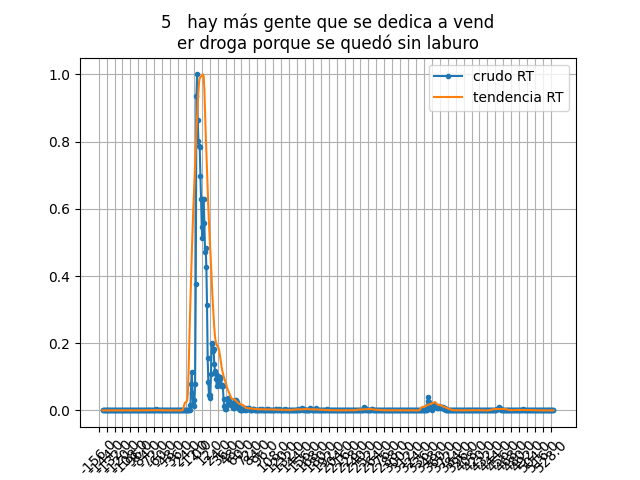

In [83]:
from statsmodels.tsa.seasonal import seasonal_decompose

%matplotlib widget
index = 5
df_clus_completo = pd.read_csv(path+f'Tw_mas_RT_october/RT_Tw_cluster_{index}.csv')
df_clus_completo['Fecha'] = pd.to_datetime(df_clus_completo['Fecha'], format='%a %b %d %H:%M:%S +0000 %Y')
df_clus_completo['HorasDesdeInicio'] = (df_clus_completo['Fecha'] - df_clus_completo['Fecha'].min()).dt.total_seconds() / 3600

categoria = 'RT'

df_categoria_true = df_clus_completo[df_clus_completo[categoria] == True]
df_categoria_false = df_clus_completo[df_clus_completo[categoria] == False]

df_categoria = [df_categoria_true, df_categoria_false]
labels = ['RT', 'Tw originales']
plt.figure()
firstpart, secondpart = citas[index][:len(citas[index])//2], citas[index][len(citas[index])//2:]
plt.title(str(index)+'   ' + firstpart+'\n'+secondpart)
for i, df1 in enumerate(df_categoria):
    df = df1.copy()
    df_index = df.set_index('Fecha')
    df_count_hora = df_index.resample('1H').count()

    df_suavizado = df_count_hora.rolling('1D', center = True).mean()
    result = seasonal_decompose(df_count_hora['Tweets'], model='additive')
    trend = result.trend.fillna(0)
    plt.plot(df_count_hora.index, df_count_hora['Tweets']/max(df_count_hora['Tweets']), label = 'crudo '+str(labels[i]), marker = '.') #Test comparation
    plt.plot(trend/max(trend), label = 'tendencia ' + labels[i])

    #plt.plot(df_suavizado.index, df_suavizado['Tweets']/max(df_suavizado['Tweets']), label = labels[i], marker = '.', linestyle = 'solid')
    #plt.plot(df_suavizado_2.index, df_suavizado_2['Tweets'], label = 'filltro ewp', marker = '.', linestyle = 'solid', color = 'k')
    #plt.xticks(pd.date_range(start=df_clus_completo['Fecha'].min(), end=df_clus_completo['Fecha'].max(), freq='12H')
#           , labels= (np.arange(df_clus_completo['HorasDesdeInicio'].min(), df_clus_completo['HorasDesdeInicio'].max(), 12)-336))
    if i ==0:
        break
plt.xticks(pd.date_range(start=df_clus_completo['Fecha'].min(), end=df_clus_completo['Fecha'].max(), freq='12H'))
plt.xticks(pd.date_range(start=df_clus_completo['Fecha'].min(), end=df_clus_completo['Fecha'].max(), freq='12H')
           , labels= (np.arange(df_clus_completo['HorasDesdeInicio'].min(), df_clus_completo['HorasDesdeInicio'].max(), 12)-165))
plt.legend()
plt.grid(0.7)
plt.xticks(rotation=45)
fecha_inicio = pd.to_datetime('2019-08-27')
fecha_fin = pd.to_datetime('2019-08-31')
#plt.xlim([fecha_inicio, fecha_fin])
#plt.savefig(path+f'imagenes_agosto/serie_{index}.png')
plt.show()

In [64]:
for i in df_clus_completo[df_clus_completo['RT'] ==False]['Tweets'][19:21]:
    pass
a = df_clus_completo[df_clus_completo['RT'] ==False].sort_values(by = 'distances').reset_index()
for i in a[a['RT'] ==False]['Tweets'][560:580]:
    pass
    #print(i)
#a
result.trend.fillna(0)

Fecha
2019-10-01 04:00:00    0.0
2019-10-01 05:00:00    0.0
2019-10-01 06:00:00    0.0
2019-10-01 07:00:00    0.0
2019-10-01 08:00:00    0.0
                      ... 
2019-10-29 21:00:00    0.0
2019-10-29 22:00:00    0.0
2019-10-29 23:00:00    0.0
2019-10-30 00:00:00    0.0
2019-10-30 01:00:00    0.0
Freq: H, Name: trend, Length: 694, dtype: float64

In [53]:
len([5, 29, 40, 48, 63, 97, 130, 131, 157, 227, 229, 232, 238, 254, 270, 272, 290, 294, 304, 349, 360, 365, 403, 427, 461, 465, 466, 469, 493, 501, 508, 540, 543, 554, 574, 609, 626, 731, 778, 816, 853, 877, 891, 899, 984, 987, 1024, 1037, 1085, 1144, 1160, 1164, 1524, 1598, 1663, 1670, 1764, 1849, 1869, 1883,  1956, 2140, 2231, 2353, 2465, 2473, 2508, 2592, 2693, 2762, 2772, 2987])
len([27, 160, 167, 173, 246, 258, 496, 688, 1125, 1503, 1980, 2217, 2335, 2754])

14

In [87]:
aug = pk.load(open(path+'ids_august_2.pk', 'rb'))
oct = pk.load(open(path+'ids_october.pk', 'rb'))
len(aug), len(oct)

(33, 75)

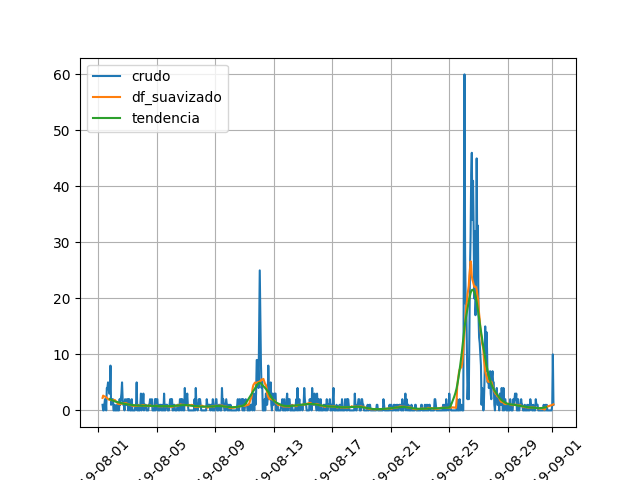

In [53]:
frecuencia = 'H'
result = seasonal_decompose(df_suavizado['Tweets'], model='additive')
plt.figure()
plt.plot(df_count_hora.index, df_count_hora['Tweets'], label = 'crudo')
plt.plot(df_suavizado.index, df_suavizado['Tweets'], label = 'df_suavizado')
plt.plot(result.trend, label = 'tendencia')
plt.legend()
plt.grid(0.7)
plt.xticks(rotation=45)
plt.show()
